In [2]:
from data_loader import data_loader, preprocess
from model_helper import get_tuned_gamma, train, tune_lambda, plot_lambda_tuning
import numpy as np
from PCA import project_and_plot_PCA, corr_plot, plot_reconstruction_loss
import pandas as pd
from Bootstrap_and_eval import eval, bootstrap_eval_one, plot_violin_metrics_with_ci_single
from NN import train_and_evaluate_nn


In [10]:
df = data_loader(num=1000)

# filter columns to only include columns in the features list below
features = ['loan_amount_000s', 'loan_type', 'owner_occupancy', 
       'property_type','applicant_income_000s', 'purchaser_type', 'hud_median_family_income',
       'tract_to_msamd_income', 'number_of_owner_occupied_units', 
       'number_of_1_to_4_family_units', 'race_ethnicity', 'state_code', 'county_code',
       'joint_sex',"minority_population", 'lien_status']

x_train, x_test, y_train, y_test, train_groups, test_groups = preprocess(df, features)

Loading data...
processed_data.csv exists. Loading data from file.
Sample size BEFORE filtering 641
Sample size AFTER filtering 468
Num features BEFORE filtering 468
Num features AFTER filtering 468
x_train shape:  (374, 16)
y_train shape:  (94, 16)


In [11]:
betas = np.random.rand(x_train.shape[1])
gammas = np.linspace(0.1, 1, 10)
best_gamma = get_tuned_gamma(gammas, x_train, y_train, num_folds=5, verbose=False)

Gamma:  0.1
Gamma:  0.2
Gamma:  0.30000000000000004
Gamma:  0.4
Gamma:  0.5
Gamma:  0.6
Gamma:  0.7000000000000001
Gamma:  0.8
Gamma:  0.9
Gamma:  1.0
Best gamma:  0.1


In [ ]:
betas = np.random.rand(x_train.shape[1])
_lambda = None 
fair_loss_ = 'NO l2'

unfair_preds = train(x_train, y_train, x_test, y_test, train_groups, fair_loss_, best_gamma, lambda_val=1)  # do use l2 regularization here ergo False


With L2

In [ ]:
betas = np.random.rand(x_train.shape[1])
_lambda = None 
fair_loss_ = False

unfair_preds = train(x_train, y_train, x_test, y_test, train_groups, best_gamma, fair_loss_) 

First tune hyperparameter lambda 

then train L2 + Fairness loss

In [ ]:
fair_loss_ = True
performance_metrics = tune_lambda(x_train, y_train, test_groups, train_groups, x_test, y_test, fair_loss_, best_gamma)

In [ ]:
lambda_vals = [0.001, 0.005, 0.01, 0.05, 0.1, 1]
plot_lambda_tuning(performance_metrics, lambda_vals)


In [ ]:
betas = np.random.rand(x_train.shape[1])
_lambda = None 
fair_loss_ = True

unfair_preds = train(x_train, y_train, x_test, y_test, train_groups, fair_loss_, best_gamma) 

In [7]:
# print shape of x_train, y_train, x_test, y_test, groups,
print("x_train shape: ", x_train.shape, type(x_train))
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape, type(x_test))
print("y_test shape: ", y_test.shape, type(y_test))
print("train groups shape: ", train_groups.shape)
print("test groups shape: ", test_groups.shape)


x_train shape:  (374, 16) <class 'numpy.ndarray'>
y_train shape:  (374,)
x_test shape:  (94, 16) <class 'numpy.ndarray'>
y_test shape:  (94,) <class 'pandas.core.series.Series'>
train groups shape:  (374, 2)
test groups shape:  (94, 2)


Fit PCA components to data

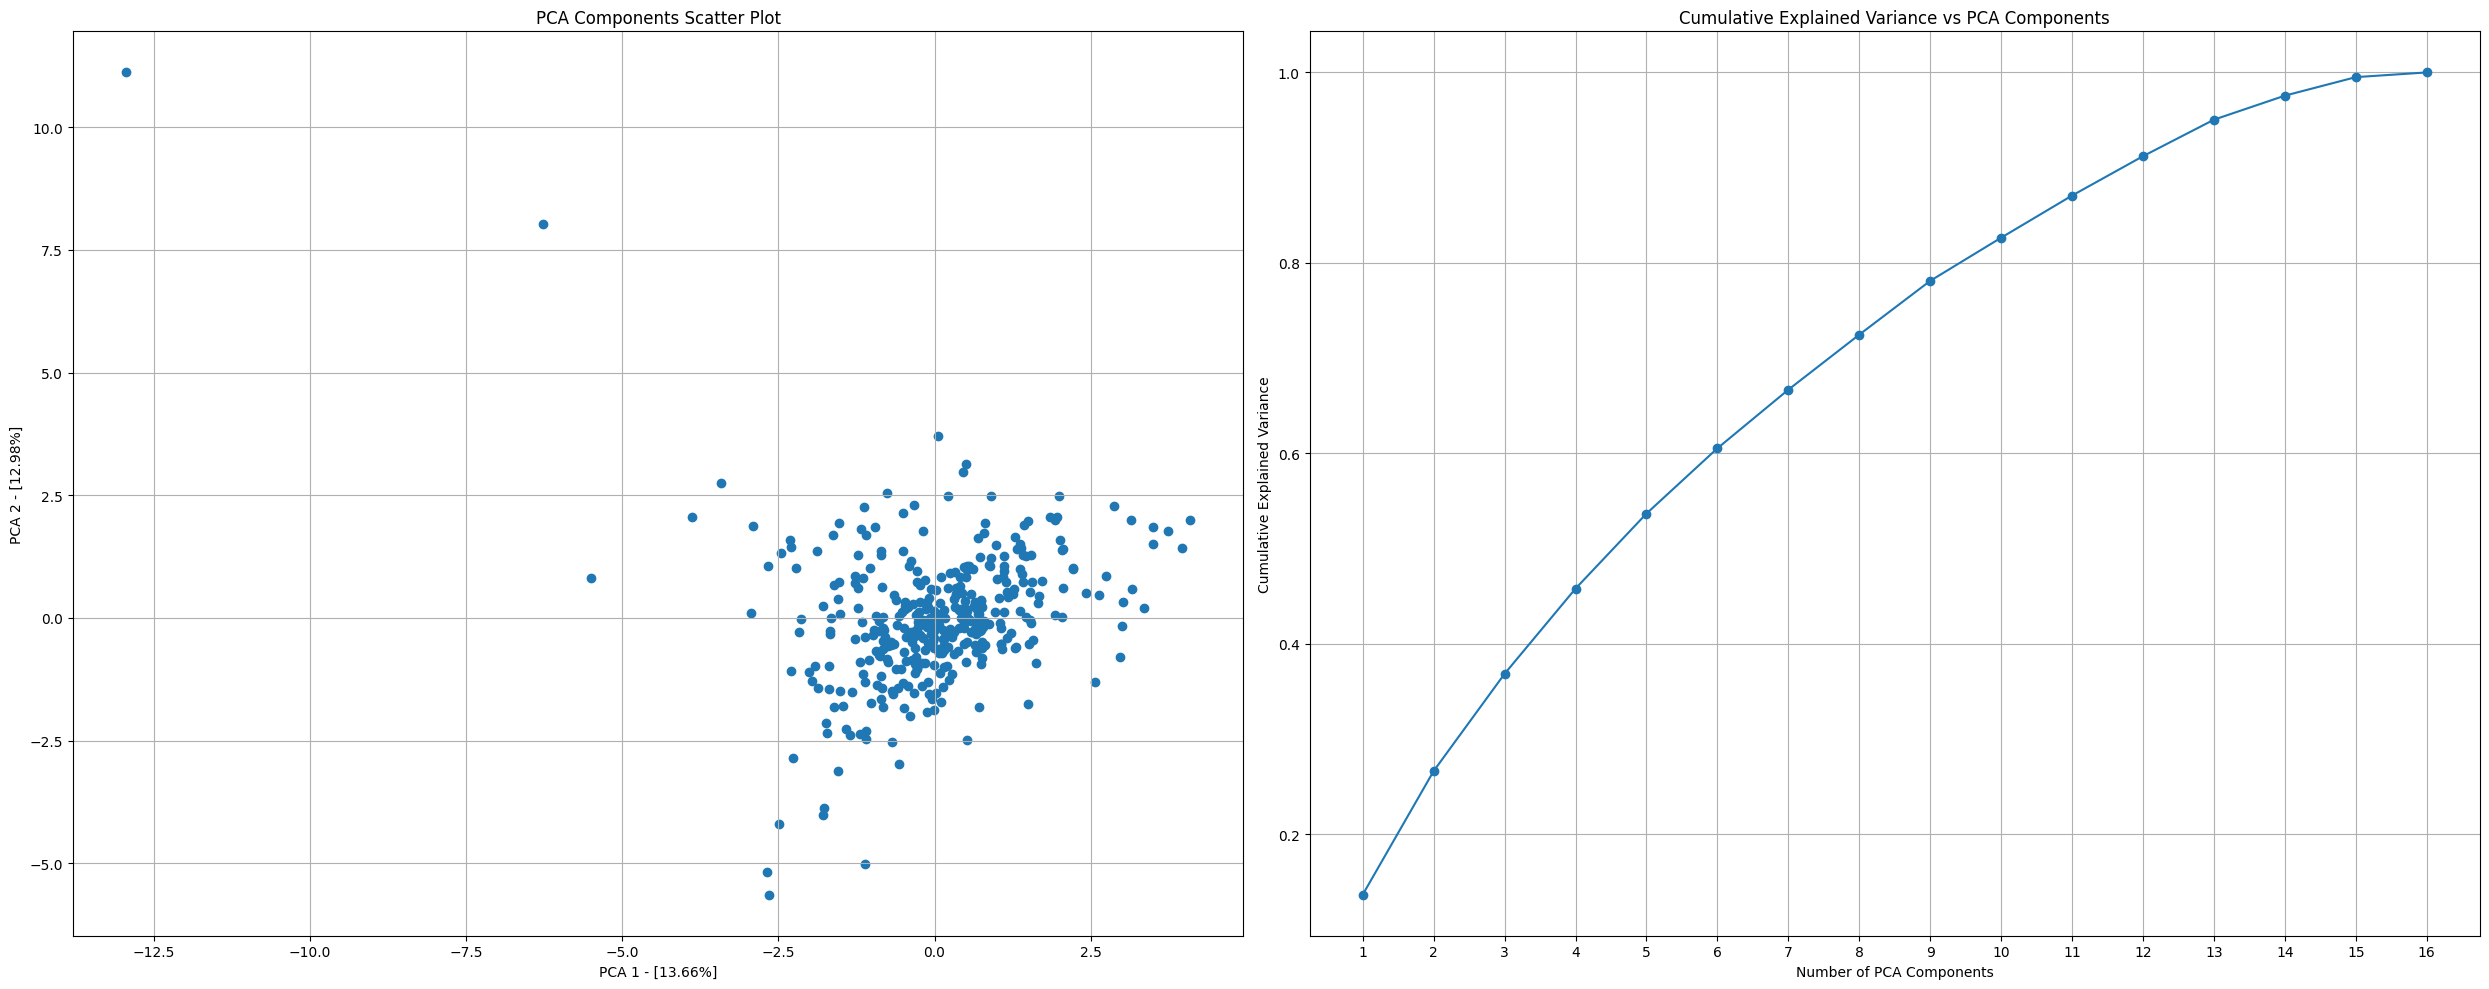

In [4]:
x_train_pd = pd.DataFrame(x_train, columns=features)
x_test_pd = pd.DataFrame(x_test, columns=features)
project_and_plot_PCA(x_train_pd, n_components=len(features), size = (25,10),corr_metric='pearson')

In [ ]:
corr_plot(x_train_pd, 'pearson', train_groups, n_components=len(features), fair=False)
corr_plot(x_train_pd, 'pearson', train_groups, n_components=len(features), fair=True)

In [ ]:
plot_reconstruction_loss(x_train_pd, x_test_pd, len(features), train_groups, fair=False)

Train model on fair PCA data 

In [6]:
normal_preds, pca_preds, fair_preds = eval(x_train_pd, x_test_pd, y_test, y_train, y_test, train_groups)

Logistic regression accuracy: 65.96%
              precision    recall  f1-score   support

           0       0.36      0.80      0.50        20
           1       0.92      0.62      0.74        74

    accuracy                           0.66        94
   macro avg       0.64      0.71      0.62        94
weighted avg       0.80      0.66      0.69        94

Logistic regression accuracy: 69.15%
              precision    recall  f1-score   support

           0       0.40      0.90      0.55        20
           1       0.96      0.64      0.76        74

    accuracy                           0.69        94
   macro avg       0.68      0.77      0.66        94
weighted avg       0.84      0.69      0.72        94

Logistic regression accuracy: 63.83%
              precision    recall  f1-score   support

           0       0.35      0.85      0.50        20
           1       0.93      0.58      0.72        74

    accuracy                           0.64        94
   macro avg     

Logistic regression accuracy: 72.34%
              precision    recall  f1-score   support

           0       0.43      0.90      0.58        20
           1       0.96      0.68      0.79        74

    accuracy                           0.72        94
   macro avg       0.70      0.79      0.69        94
weighted avg       0.85      0.72      0.75        94



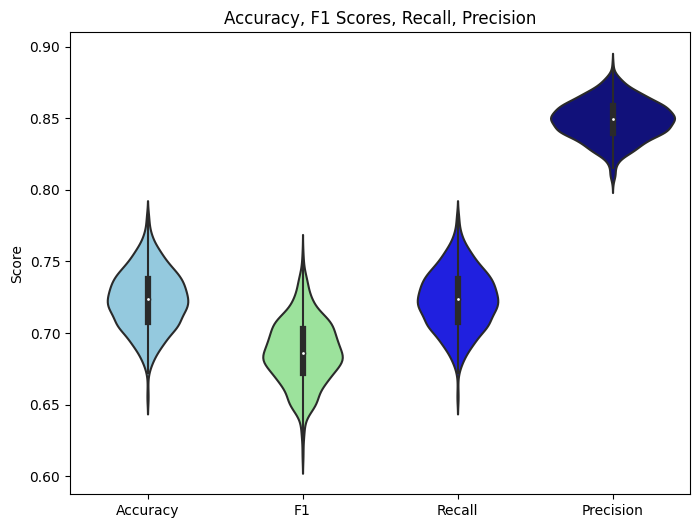

Accuracy CI: (0.7220387434003397, 0.7246212565996601)
F1 CI: (0.6856039170583819, 0.6883872029627198)
Precision CI: (0.8480481867182678, 0.849737314009046)
Recall CI: (0.7220387434003397, 0.7246212565996601)


In [12]:
unfair_preds = train(x_train, y_train, x_test, y_test, train_groups, fair_loss_=False, best_gamma=best_gamma)  # do use l2 regularization here ergo False
n_bootstrap = 1000
sample_size = 500
accuracy_scores, f1_scores, precision_scores, recall_scores = bootstrap_eval_one(unfair_preds, None, y_test, n_bootstrap, sample_size)
plot_violin_metrics_with_ci_single(accuracy_scores, f1_scores, precision_scores, recall_scores, confidence_level=0.95)


BLACK BOX MODEL

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

clf = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000, alpha=0.0001)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred))


(94, 16) <class 'numpy.ndarray'>
Epoch 1/20, Loss: 0.7169009745121002
Epoch 2/20, Loss: 0.5621162429451942
Epoch 3/20, Loss: 0.5033130496740341
Epoch 4/20, Loss: 0.46469156940778095
Epoch 5/20, Loss: 0.4317836215098699
Epoch 6/20, Loss: 0.4152882744868596
Epoch 7/20, Loss: 0.3872217411796252
Epoch 8/20, Loss: 0.3744506165385246
Epoch 9/20, Loss: 0.36238061636686325
Epoch 10/20, Loss: 0.3480413171152274
Epoch 11/20, Loss: 0.33876366664965946
Epoch 12/20, Loss: 0.32955915853381157
Epoch 13/20, Loss: 0.32017919172843295
Epoch 14/20, Loss: 0.3100499324500561
Epoch 15/20, Loss: 0.30532995363076526
Epoch 16/20, Loss: 0.29629771535595256
Epoch 17/20, Loss: 0.28905852138996124
Epoch 18/20, Loss: 0.2798691354691982
Epoch 19/20, Loss: 0.27373956019679707
Epoch 20/20, Loss: 0.2696591665347417


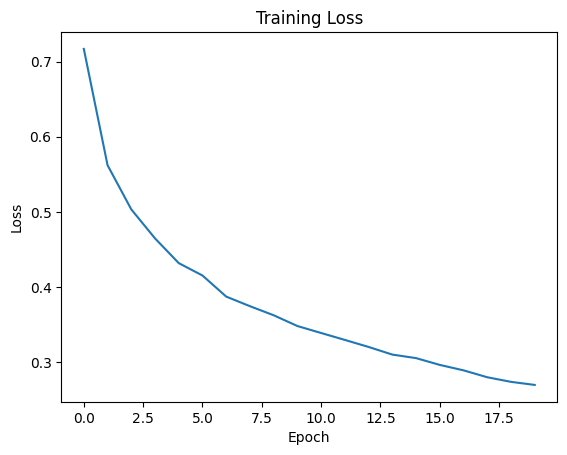

Test Accuracy: 84.04255319148936%


(SimpleNN(
   (fc1): Linear(in_features=16, out_features=128, bias=True)
   (relu): ReLU()
   (fc2): Linear(in_features=128, out_features=2, bias=True)
 ),
 84.04255319148936)

In [13]:
x_train_np = np.array(x_train)
y_train_np = np.array(y_train)
x_test_np = np.array(x_test)
y_test_np = np.array(y_test)

train_and_evaluate_nn(x_train_np, x_test_np, y_train_np, y_test_np, plot_loss=True)
